In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Cargar datos
df = pd.read_csv("tb_datos_modelo_final.csv")

# --- Definir variables predictoras y target
X = df.drop(columns=['prevalencia_contactos'])  # target = prevalencia_contactos
y = df['prevalencia_contactos']

# --- Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# --- Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# --- Split antes del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [95]:
# =====================================
# 📘 MODELOS DE REGRESIÓN ACTUALIZADOS
# =====================================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

models = {
    # --- 1️⃣ Regresión Lineal ---
    "Regresión Lineal": LinearRegression(
        fit_intercept=True,
        copy_X=True,
        n_jobs=-1
    ),

    # --- 2️⃣ Ridge ---
    "Ridge": Ridge(
        alpha=1.0,
        solver='auto',
        tol=1e-4,
        max_iter=10000,
        random_state=42
    ),

    # --- 3️⃣ Lasso ---
    "Lasso": Lasso(
        alpha=0.001,
        tol=1e-4,
        max_iter=10000,
        selection='cyclic',
        random_state=42
    ),

    # --- 4️⃣ Random Forest ---
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features='log2',
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ),

    # --- 5️⃣ Gradient Boosting ---
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.9,
        loss='squared_error',
        random_state=42
    ),

    # --- 6️⃣ Support Vector Regression (SVR) ---
    "SVR_rbf": SVR(
        kernel='rbf',
        C=10,               # regularización
        epsilon=0.1,        # margen de tolerancia
        gamma='scale'       # kernel gaussiano
    ),

    # --- 7️⃣ XGBoost ---
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        tree_method="gpu_hist",   # 🚀 usa GPU si está disponible
        predictor="gpu_predictor" # fallback automático a GPU
    )
}

Regresión Lineal -> R2_train: 0.2359, R2_test: 0.2406, MAE: 3.9778, RMSE: 5.5649


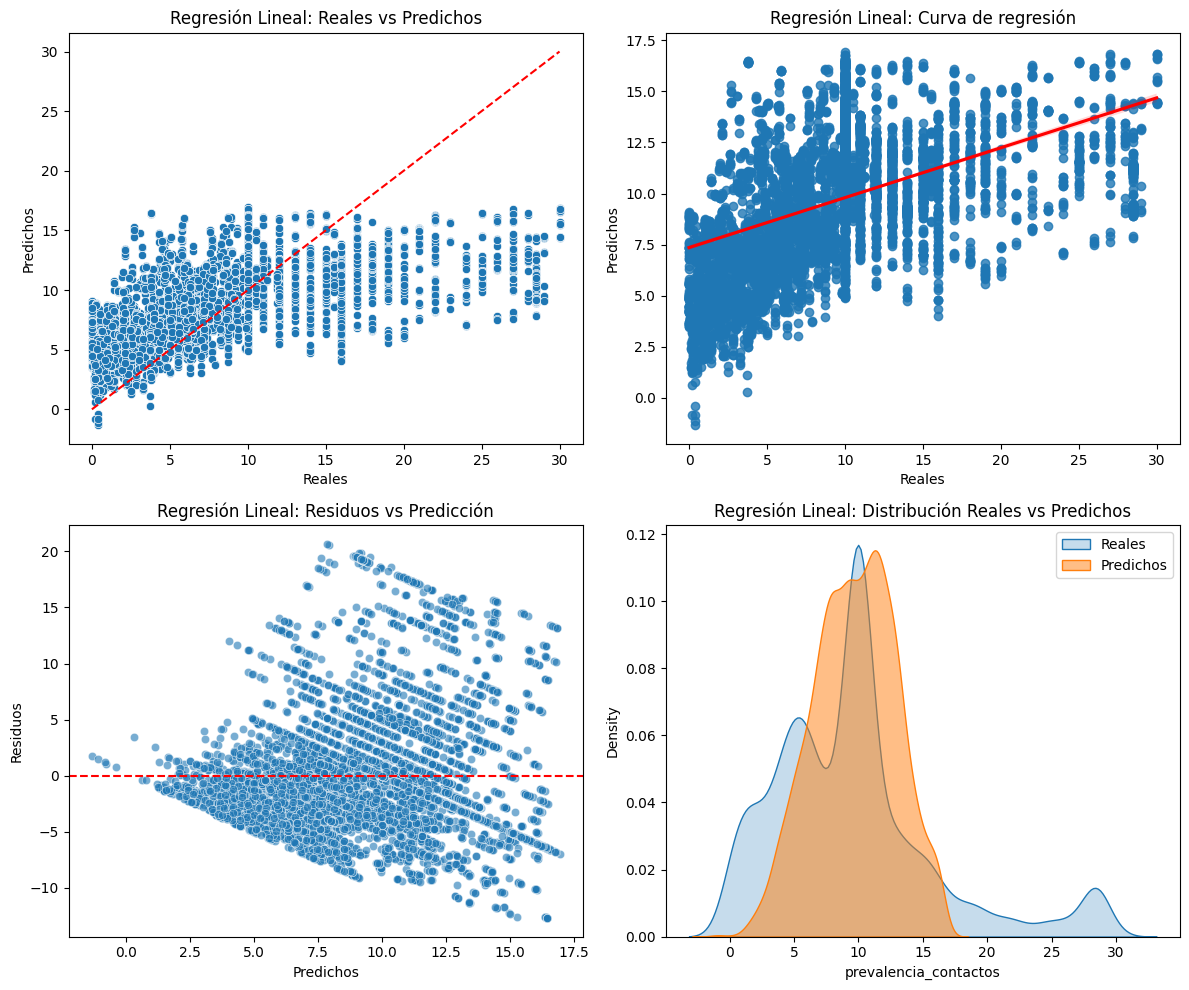

In [96]:
from sklearn.model_selection import cross_val_predict

results = []
model_name = "Regresión Lineal"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })


Ridge -> R2_train: 0.2359, R2_test: 0.2406, MAE: 3.9778, RMSE: 5.5649


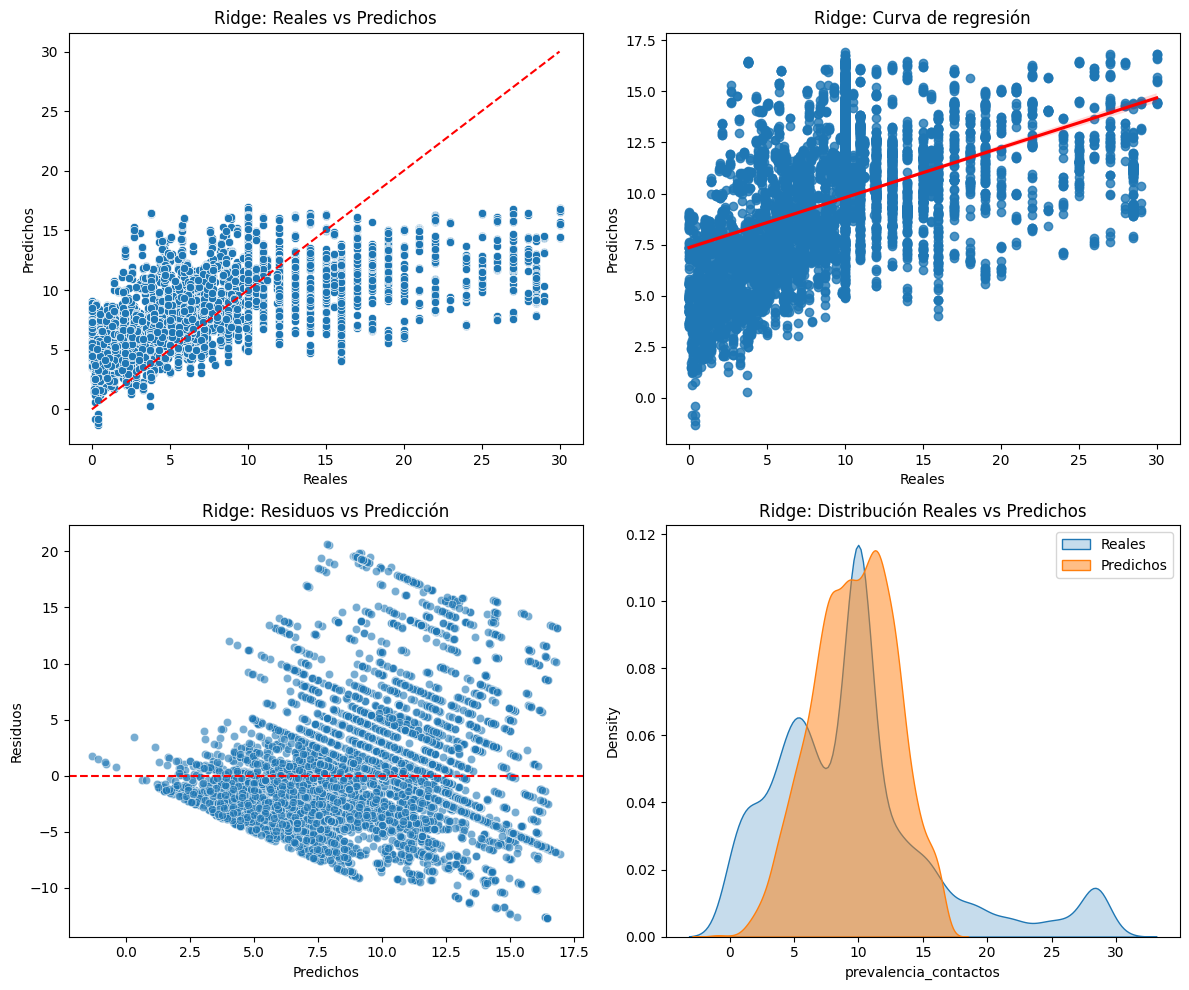

In [97]:
from sklearn.model_selection import cross_val_predict

model_name = "Ridge"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })


Lasso -> R2_train: 0.2359, R2_test: 0.2406, MAE: 3.9777, RMSE: 5.5649


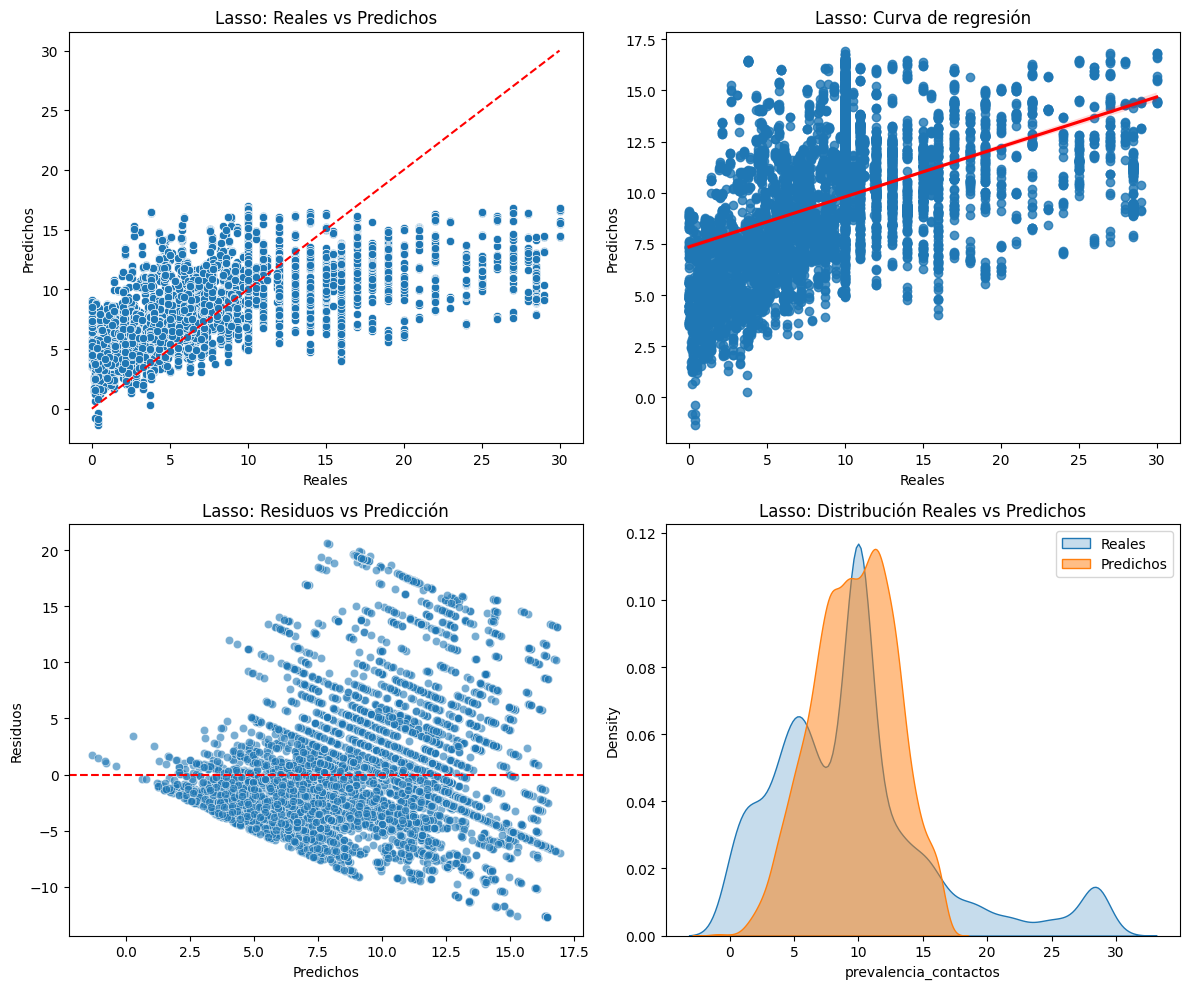

In [98]:
from sklearn.model_selection import cross_val_predict

model_name = "Lasso"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })



Random Forest -> R2_train: 0.8477, R2_test: 0.8511, MAE: 1.5914, RMSE: 2.4641


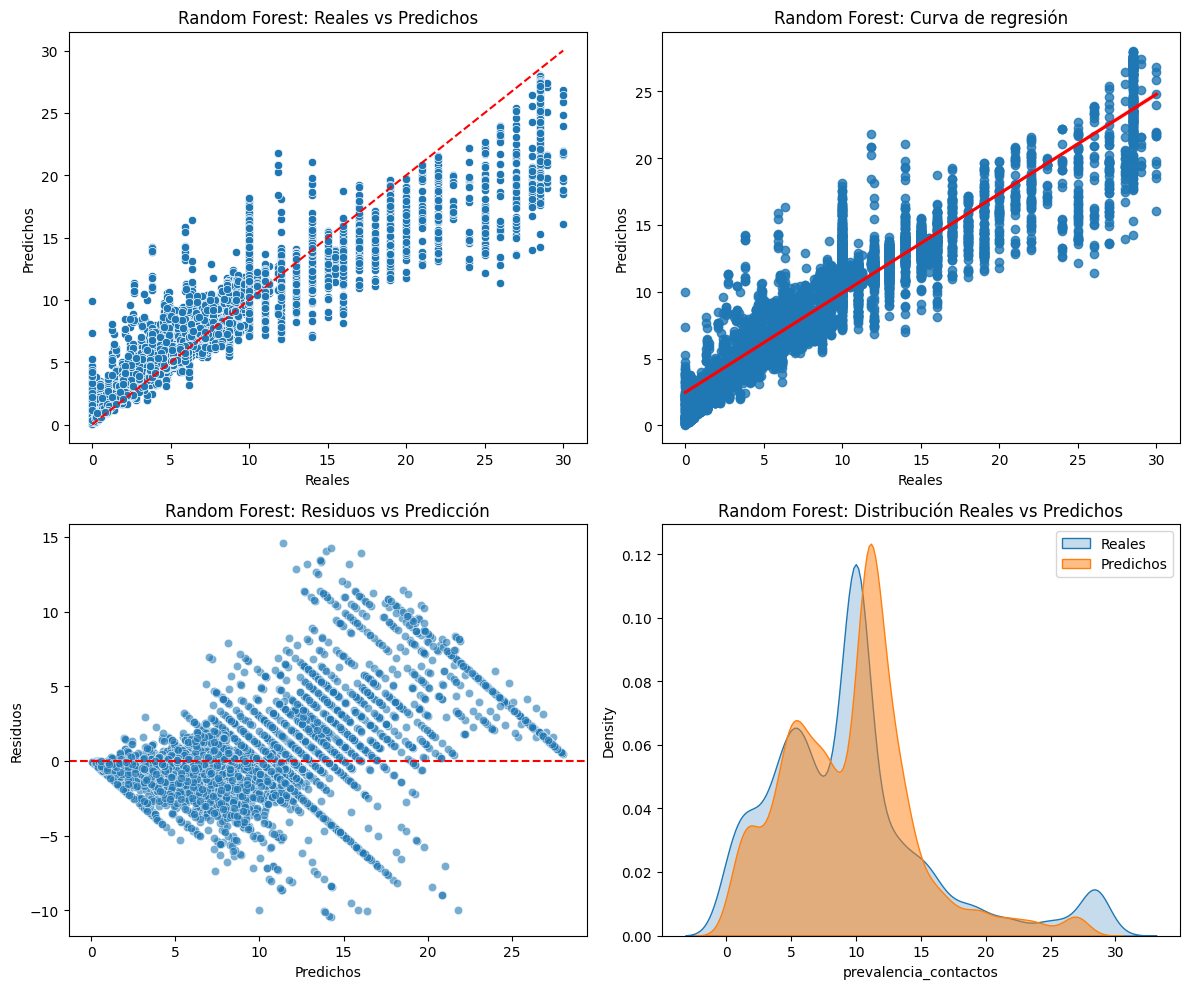

In [99]:
from sklearn.model_selection import cross_val_predict

model_name = "Random Forest"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })


Gradient Boosting -> R2_train: 0.7131, R2_test: 0.7058, MAE: 2.4698, RMSE: 3.4639


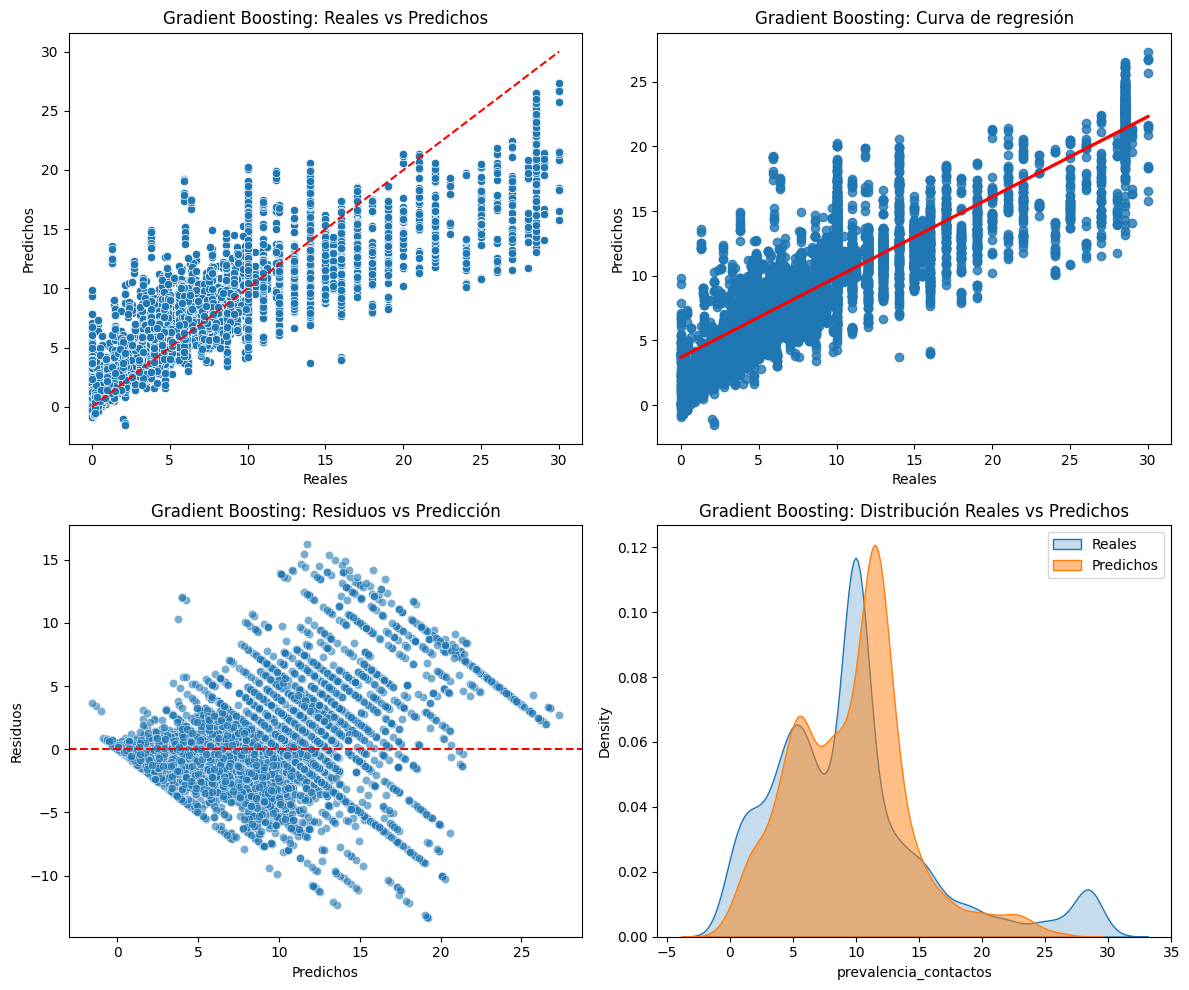

In [100]:
from sklearn.model_selection import cross_val_predict

model_name = "Gradient Boosting"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })


SVR_rbf -> R2_train: 0.3123, R2_test: 0.3285, MAE: 2.8932, RMSE: 5.2330


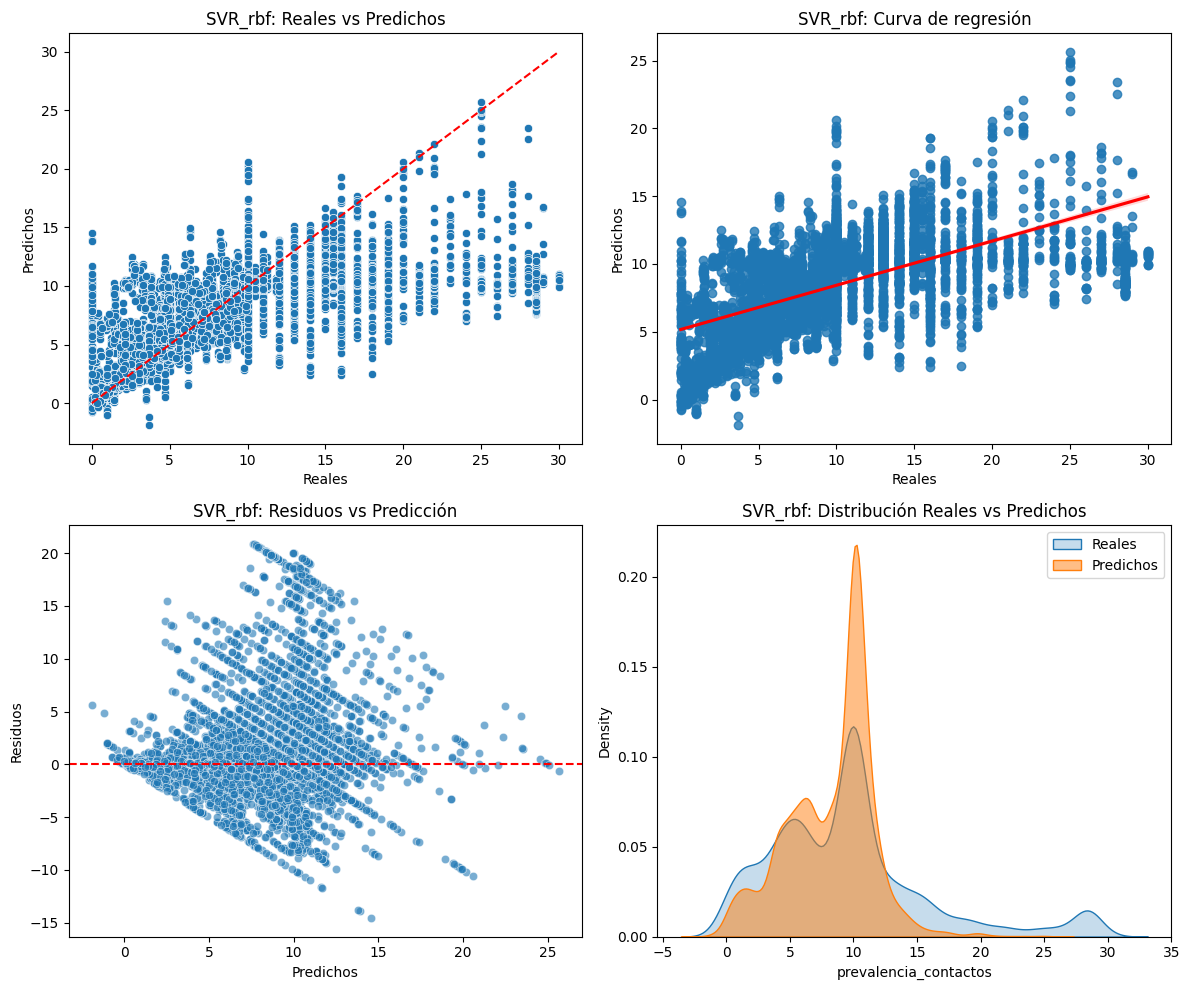

In [101]:
from sklearn.model_selection import cross_val_predict

model_name = "SVR_rbf"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:13:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:13:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:13:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-

XGBoost -> R2_train: 0.8970, R2_test: 0.9014, MAE: 1.3436, RMSE: 2.0052


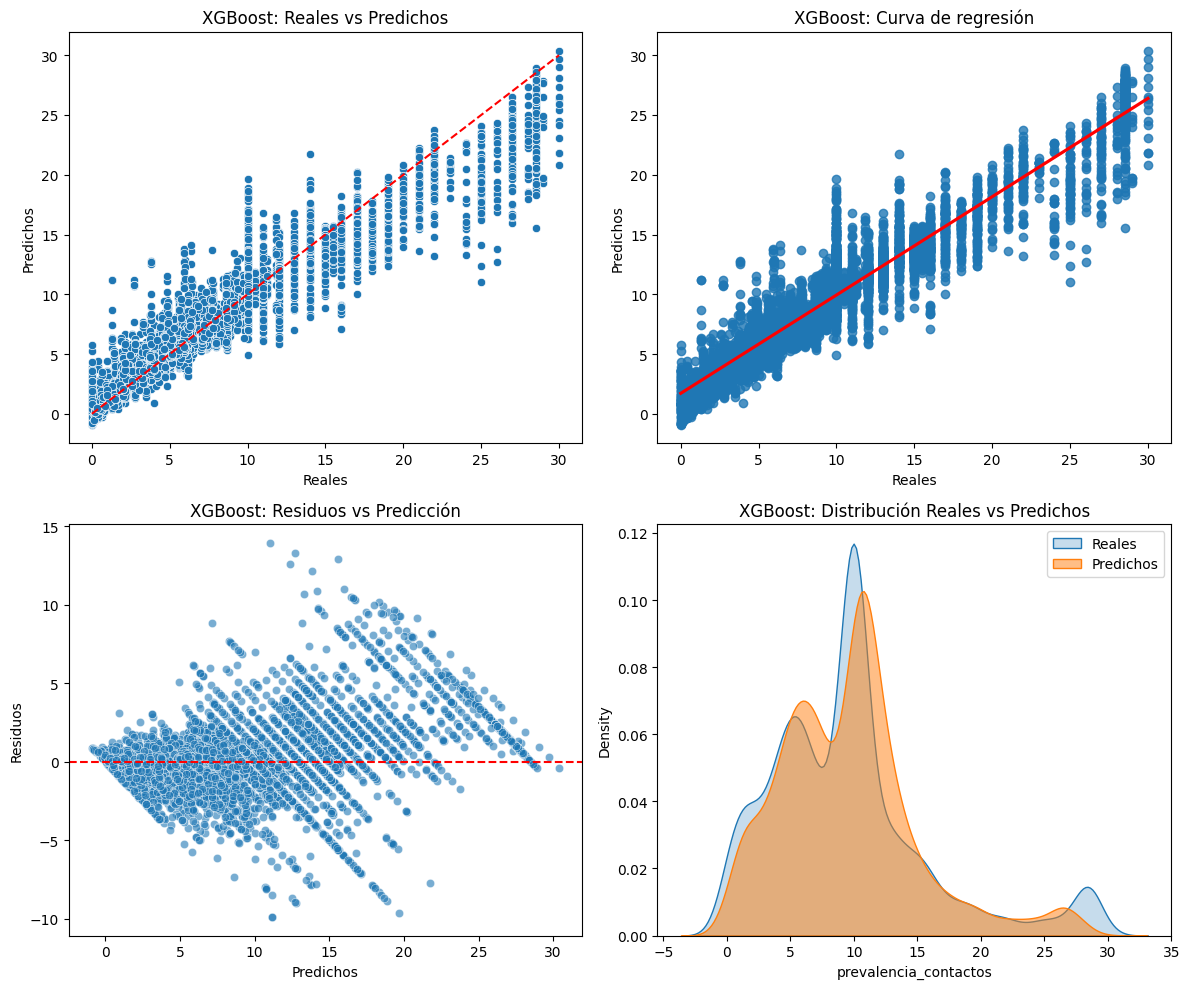

In [102]:
from sklearn.model_selection import cross_val_predict

model_name = "XGBoost"
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[model_name])])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(reg, X_train, y_train, cv=cv)

r2_train = cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2').mean()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"{model_name} -> R2_train: {r2_train:.4f}, R2_test: {r2_test:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1️⃣ Real vs Predicho ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title(f"{model_name}: Reales vs Predichos")
axes[0, 0].set_xlabel("Reales")
axes[0, 0].set_ylabel("Predichos")

# --- 2️⃣ Curva de regresión ajustada ---
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title(f"{model_name}: Curva de regresión")
axes[0, 1].set_xlabel("Reales")
axes[0, 1].set_ylabel("Predichos")

# --- 3️⃣ Residuos vs Predicción ---
residuos = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title(f"{model_name}: Residuos vs Predicción")
axes[1, 0].set_xlabel("Predichos")
axes[1, 0].set_ylabel("Residuos")

# --- 4️⃣ Distribución Reales vs Predichos ---
sns.kdeplot(y_test, label='Reales', fill=True, ax=axes[1, 1])
sns.kdeplot(y_pred, label='Predichos', fill=True, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title(f"{model_name}: Distribución Reales vs Predichos")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results.append({
        "Modelo": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE": mae,
        "RMSE": rmse
    })


In [103]:
df_results = pd.DataFrame(results)
display(df_results)


,Modelo,R2_train,R2_test,MAE,RMSE
0,Regresión Lineal,0.235874,0.240582,3.977793,5.564920
1,Ridge,0.235874,0.240583,3.977794,5.564919
2,Lasso,0.235874,0.240593,3.977719,5.564883
3,Random Forest,0.847677,0.851107,1.591435,2.464086
4,Gradient Boosting,0.713065,0.705761,2.469793,3.463925
5,SVR_rbf,0.312278,0.328484,2.893198,5.232954
6,XGBoost,0.897041,0.901398,1.343602,2.005222


C:\Users\taran\AppData\Local\Temp\ipykernel_22956\3039141648.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results.sort_values("R2_test", ascending=False),
C:\Users\taran\AppData\Local\Temp\ipykernel_22956\3039141648.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results.sort_values("MAE", ascending=True),
C:\Users\taran\AppData\Local\Temp\ipykernel_22956\3039141648.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results.sort_values("RMSE", ascending=True),


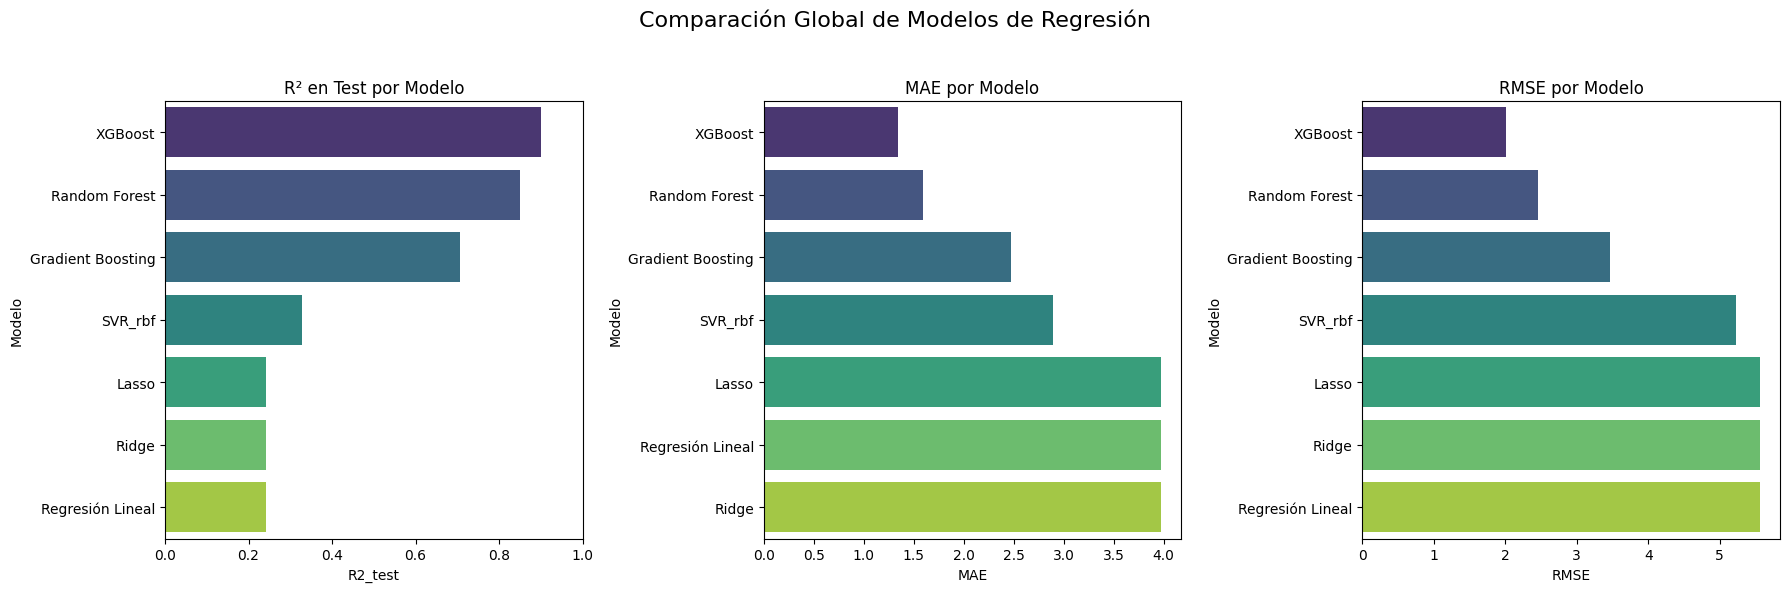

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- R2 ---
sns.barplot(data=df_results.sort_values("R2_test", ascending=False),
            x="R2_test", y="Modelo", ax=axes[0], palette="viridis")
axes[0].set_title("R² en Test por Modelo")
axes[0].set_xlim(0, 1)

# --- MAE ---
sns.barplot(data=df_results.sort_values("MAE", ascending=True),
            x="MAE", y="Modelo", ax=axes[1], palette="viridis")
axes[1].set_title("MAE por Modelo")

# --- RMSE ---
sns.barplot(data=df_results.sort_values("RMSE", ascending=True),
            x="RMSE", y="Modelo", ax=axes[2], palette="viridis")
axes[2].set_title("RMSE por Modelo")

plt.suptitle("Comparación Global de Modelos de Regresión", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [112]:
import joblib
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- Top 3 modelos según R2_test ---
df_top3 = df_results.sort_values("R2_test", ascending=False).head(3)
print("🏆 Top 3 modelos por R2_test:")
print(df_top3[["Modelo", "R2_test"]])

# --- Entrenar y guardar los 3 mejores modelos ---
for i, row in enumerate(df_top3.itertuples(), start=1):
    model_name = row.Modelo

    # Seleccionar e instanciar el modelo según el nombre
    if model_name == "XGBoost":
        model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            tree_method="gpu_hist",
            predictor="gpu_predictor"
        )

    elif model_name == "Random Forest":
        model = RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=1,
            max_features=0.8,
            random_state=42,
            n_jobs=-1
        )

    elif model_name == "Gradient Boosting":
        model = GradientBoostingRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            loss="squared_error",
            random_state=42
        )
    else:
        print(f"⚠️ Modelo no reconocido: {model_name}")
        continue

    # Entrenar
    print(f"\n🚀 Entrenando {model_name} ...")
    model.fit(X_train, y_train)

    # Guardar modelo
    filename = f"modelo_top{i}_{model_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    print(f"✅ {model_name} guardado como {filename}")


🏆 Top 3 modelos por R2_test:
              Modelo   R2_test
6            XGBoost  0.901398
3      Random Forest  0.851107
4  Gradient Boosting  0.705761

🚀 Entrenando XGBoost ...


c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\gpu_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-

✅ XGBoost guardado como modelo_top1_xgboost.pkl

🚀 Entrenando Random Forest ...
✅ Random Forest guardado como modelo_top2_random_forest.pkl

🚀 Entrenando Gradient Boosting ...
✅ Gradient Boosting guardado como modelo_top3_gradient_boosting.pkl
